## Test Healthcare Sector

In [8]:
USE_DRIVE = False

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Northwestern/MSDS451_FinancialMachineLearning' if USE_DRIVE else '/content'
DATA_DIR = f'{BASE_DIR}/data'
RAW_DIR = f'{DATA_DIR}/raw'
PROCESSED_DIR = f'{DATA_DIR}/processed'
FIG_DIR = f'{BASE_DIR}/figures'
RESULTS_DIR = f'{BASE_DIR}/results'

import os
for d in [DATA_DIR, RAW_DIR, PROCESSED_DIR, FIG_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Saving under:", BASE_DIR)


Saving under: /content


In [10]:
# !pip -q install yfinance==0.2.43 pandas numpy matplotlib seaborn

import os, time, random
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,6)


In [11]:
START_DATE = "1999-01-01"
END_DATE   = "2024-12-31"

# 15-stock healthcare universe
healthcare_universe = [
    # Big Pharmaceuticals
    {"ticker": "JNJ",  "subsector": "Pharma"},
    {"ticker": "PFE",  "subsector": "Pharma"},
    {"ticker": "MRK",  "subsector": "Pharma"},
    {"ticker": "ABBV", "subsector": "Pharma"},
    {"ticker": "LLY",  "subsector": "Pharma"},
    # Biotech
    {"ticker": "AMGN", "subsector": "Biotech"},
    {"ticker": "REGN", "subsector": "Biotech"},
    {"ticker": "VRTX", "subsector": "Biotech"},
    # Insurance
    {"ticker": "UNH",  "subsector": "Insurance"},
    {"ticker": "HUM",  "subsector": "Insurance"},
    {"ticker": "CI",   "subsector": "Insurance"},
    # Devices
    {"ticker": "TMO",  "subsector": "Devices"},
    {"ticker": "MDT",  "subsector": "Devices"},
    {"ticker": "BSX",  "subsector": "Devices"},
    # Services
    {"ticker": "CVS",  "subsector": "Services"},
]

benchmark_ticker = "XLV"  # Health Care Select Sector from S&P 500
universe_df = pd.DataFrame(healthcare_universe)
universe_df.to_csv(f"{DATA_DIR}/healthcare_universe.csv", index=False)
universe_df


,ticker,subsector
0,JNJ,Pharma
1,PFE,Pharma
2,MRK,Pharma
3,ABBV,Pharma
4,LLY,Pharma
5,AMGN,Biotech
6,REGN,Biotech
7,VRTX,Biotech
8,UNH,Insurance
9,HUM,Insurance


In [12]:
def download_one(ticker: str, start: str, end: str, max_retries: int = 5) -> pd.DataFrame:
    """
    Per-ticker download with auto_adjust, retries, and a single 'ticker' column of adjusted closes.
    """
    delay = 1.0
    for attempt in range(max_retries):
        try:
            df = yf.download(
                ticker,
                start=start,
                end=end,
                auto_adjust=True,  # 'Close' returned is already adjusted
                progress=False,
                threads=False,
            )
            if isinstance(df, pd.DataFrame) and not df.empty:
                out = df[['Close']].copy()
                out.columns = [ticker]
                return out
            else:
                print(f"[WARN] Empty data for {ticker} in {start}..{end}")
                return pd.DataFrame()
        except Exception as e:
            print(f"[ERROR] {ticker} attempt {attempt+1}/{max_retries}: {e}")
            time.sleep(delay + random.random())
            delay *= 2.0
    print(f"[FAIL] {ticker} exhausted retries.")
    return pd.DataFrame()

def polite_pause(seconds=1.0): time.sleep(seconds)

def pull_prices(tickers, start, end, per_call_pause=1.0) -> pd.DataFrame:
    frames = []
    for i, t in enumerate(tickers, start=1):
        print(f"({i}/{len(tickers)}) {t}")
        frames.append(download_one(t, start, end))
        polite_pause(per_call_pause)
    prices = pd.concat(frames, axis=1)
    prices.sort_index(inplace=True)
    return prices


In [13]:
hc_tickers = list(universe_df['ticker'])
tickers_all = hc_tickers + [benchmark_ticker]

prices = pull_prices(tickers_all, START_DATE, END_DATE, per_call_pause=1.0)

# Save raw adjusted close prices
prices_path = f"{PROCESSED_DIR}/healthcare_prices_adjclose.csv"
prices.to_csv(prices_path)
prices.tail()


(1/16) JNJ
(2/16) PFE
(3/16) MRK
(4/16) ABBV
(5/16) LLY
(6/16) AMGN
(7/16) REGN
(8/16) VRTX
(9/16) UNH
(10/16) HUM
(11/16) CI
(12/16) TMO
(13/16) MDT
(14/16) BSX
(15/16) CVS
(16/16) XLV


,JNJ,PFE,MRK,ABBV,LLY,AMGN,REGN,VRTX,UNH,HUM,CI,TMO,MDT,BSX,CVS,XLV
Date,,,,,,,,,,,,,,,,
2024-12-23,141.850220,25.346369,97.542267,173.605774,791.545410,257.501221,712.077393,405.269989,500.631378,253.078613,278.909668,524.302734,79.407211,89.860001,42.675880,137.558563
2024-12-24,142.416550,25.374836,97.620789,175.172607,790.938965,257.979126,711.420166,408.179993,500.394104,252.860901,277.354797,527.985840,79.543777,91.070000,42.782230,138.123688
2024-12-26,142.152908,25.204027,98.033066,174.394073,789.418152,256.701355,713.620728,410.649994,505.387177,253.474457,278.860138,526.189209,79.602318,91.449997,43.430008,138.401291
2024-12-27,141.635391,25.260965,97.866188,173.235962,778.513306,256.184418,709.359070,408.760010,504.240234,252.979630,276.017822,525.081299,79.444870,90.660004,43.014278,137.756851
2024-12-30,139.965637,25.071175,96.560661,171.474518,769.238831,252.916901,699.590942,399.350006,502.074921,251.613998,272.482330,517.864868,78.333008,89.680000,42.482513,136.061539


In [14]:
def coverage_report(prices: pd.DataFrame, start: str, end: str):
    rows = []
    start_dt, end_dt = pd.to_datetime(start), pd.to_datetime(end)
    for col in prices.columns:
        s = prices[col].dropna()
        if s.empty:
            rows.append((col, None, None, 0, 0.0))
            continue
        first, last = s.index.min(), s.index.max()
        days = (last - first).days
        full_days = (end_dt - start_dt).days
        pct = 100.0 * days / full_days if full_days > 0 else np.nan
        rows.append((col, first.date(), last.date(), days, pct))
    rep = pd.DataFrame(rows, columns=["Ticker","FirstDate","LastDate","DaysCovered","PctOf(1999-2024)"])
    return rep.sort_values("FirstDate")

coverage = coverage_report(prices, START_DATE, END_DATE)
coverage.to_csv(f"{RESULTS_DIR}/healthcare_coverage.csv", index=False)
coverage


,Ticker,FirstDate,LastDate,DaysCovered,PctOf(1999-2024)
0,JNJ,1999-01-04,2024-12-30,9492,99.957877
1,PFE,1999-01-04,2024-12-30,9492,99.957877
2,MRK,1999-01-04,2024-12-30,9492,99.957877
4,LLY,1999-01-04,2024-12-30,9492,99.957877
5,AMGN,1999-01-04,2024-12-30,9492,99.957877
6,REGN,1999-01-04,2024-12-30,9492,99.957877
7,VRTX,1999-01-04,2024-12-30,9492,99.957877
8,UNH,1999-01-04,2024-12-30,9492,99.957877
9,HUM,1999-01-04,2024-12-30,9492,99.957877
10,CI,1999-01-04,2024-12-30,9492,99.957877


In [15]:
prices_aligned = prices.dropna()  # drops NaN across any ticker

# Save aligned prices
prices_aligned_path = f"{PROCESSED_DIR}/healthcare_prices_adjclose_aligned.csv"
prices_aligned.to_csv(prices_aligned_path)

# Log returns in percent
log_returns = 100 * np.log(prices_aligned / prices_aligned.shift(1))
log_returns = log_returns.dropna()

# Separate custom ETF constituents vs benchmark
hc_returns = log_returns[hc_tickers]
xlv_returns = log_returns[benchmark_ticker]

# Save returns
log_returns.to_csv(f"{PROCESSED_DIR}/healthcare_logreturns.csv")
hc_returns.to_csv(f"{PROCESSED_DIR}/healthcare_logreturns_constituents.csv")
xlv_returns.to_frame().to_csv(f"{PROCESSED_DIR}/healthcare_logreturns_XLV.csv")
log_returns.tail()


,JNJ,PFE,MRK,ABBV,LLY,AMGN,REGN,VRTX,UNH,HUM,CI,TMO,MDT,BSX,CVS,XLV
Date,,,,,,,,,,,,,,,,
2024-12-23,0.552236,1.319028,1.337273,1.587727,3.647367,0.235124,1.874475,1.993736,1.234031,3.436822,1.686555,0.236339,0.455597,1.017853,-0.497179,0.993736
2024-12-24,0.398450,0.112250,0.080468,0.898475,-0.076645,0.185421,-0.092340,0.715475,-0.047406,-0.086063,-0.559042,0.700021,0.171834,1.337553,0.248894,0.409983
2024-12-26,-0.185291,-0.675418,0.421436,-0.445429,-0.192465,-0.496531,0.308842,0.603302,0.992883,0.242352,0.541281,-0.340860,0.073568,0.416390,1.502779,0.200780
2024-12-27,-0.364721,0.225654,-0.170371,-0.666292,-1.391007,-0.201580,-0.598978,-0.461304,-0.227201,-0.195409,-1.024492,-0.210776,-0.197989,-0.867606,-0.961851,-0.466719
2024-12-30,-1.185914,-0.754157,-1.342969,-1.021994,-1.198459,-1.283659,-1.386605,-2.328997,-0.430346,-0.541281,-1.289167,-1.383877,-1.409425,-1.086850,-1.243957,-1.238291


In [16]:
# Summary stats
summary = hc_returns.describe(percentiles=[.05,.25,.5,.75,.95]).T
summary["skew"] = hc_returns.skew()
summary["kurt"] = hc_returns.kurt()
summary.to_csv(f"{RESULTS_DIR}/healthcare_summary_stats.csv")
summary.head(10)


,count,mean,std,min,5%,25%,50%,75%,95%,max,skew,kurt
JNJ,3018.0,0.034396,1.096782,-10.578135,-1.601637,-0.467961,0.042158,0.590981,1.559470,7.694015,-0.356413,9.589785
PFE,3018.0,0.017684,1.395904,-8.050170,-2.081940,-0.671181,0.000000,0.698900,2.235580,10.305476,0.128110,4.947818
MRK,3018.0,0.042597,1.323593,-10.384010,-1.977513,-0.622394,0.035857,0.738502,1.978722,9.901251,-0.153168,7.630480
ABBV,3018.0,0.069502,1.670768,-17.736258,-2.408138,-0.699399,0.130032,0.898428,2.443629,12.898496,-1.000743,12.494362
LLY,3018.0,0.099707,1.649981,-11.109434,-2.335976,-0.669901,0.093587,0.847472,2.489432,14.565497,0.676909,10.420080
AMGN,3018.0,0.046067,1.568139,-10.075583,-2.335885,-0.736427,0.036933,0.860876,2.382997,11.170193,0.151103,5.368170
REGN,3018.0,0.044903,2.071792,-11.081261,-3.199963,-1.129387,0.016588,1.095763,3.285198,17.266521,0.520842,4.482284
VRTX,3018.0,0.073348,2.425865,-23.187527,-3.205200,-1.079034,0.071949,1.154141,3.262054,48.184922,3.473083,69.749314
UNH,3018.0,0.080032,1.589579,-18.967122,-2.286696,-0.674462,0.096771,0.831718,2.379890,12.043660,-0.405741,13.286387
HUM,3018.0,0.046488,1.945533,-21.531506,-2.649200,-0.733514,0.079727,0.903204,2.629565,18.492448,-0.665787,17.271414


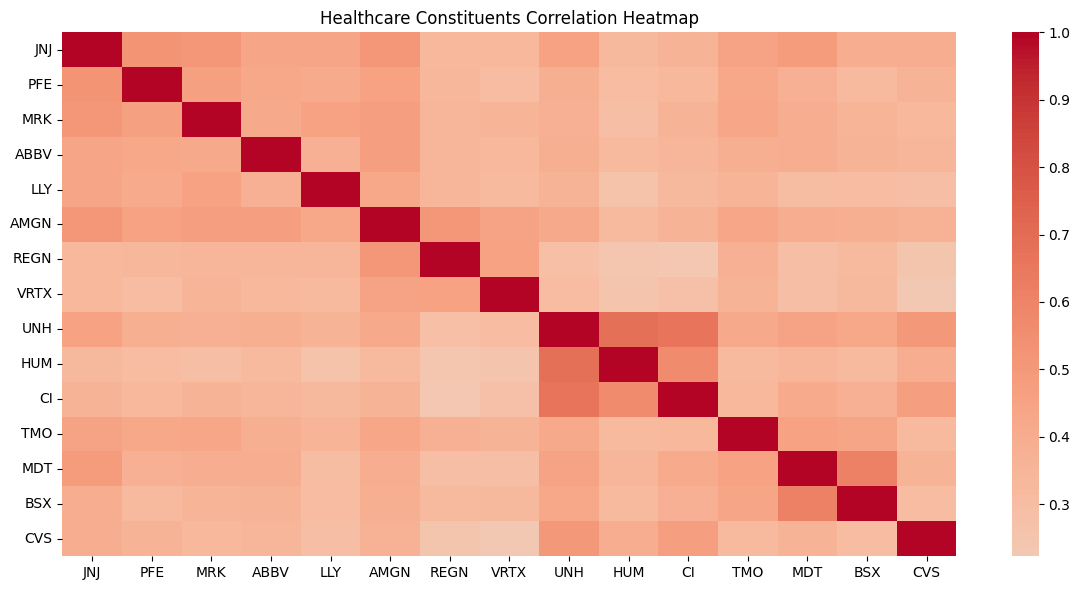

In [17]:
# Correlations
corr = hc_returns.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Healthcare Constituents Correlation Heatmap")
plt.tight_layout(); plt.show()


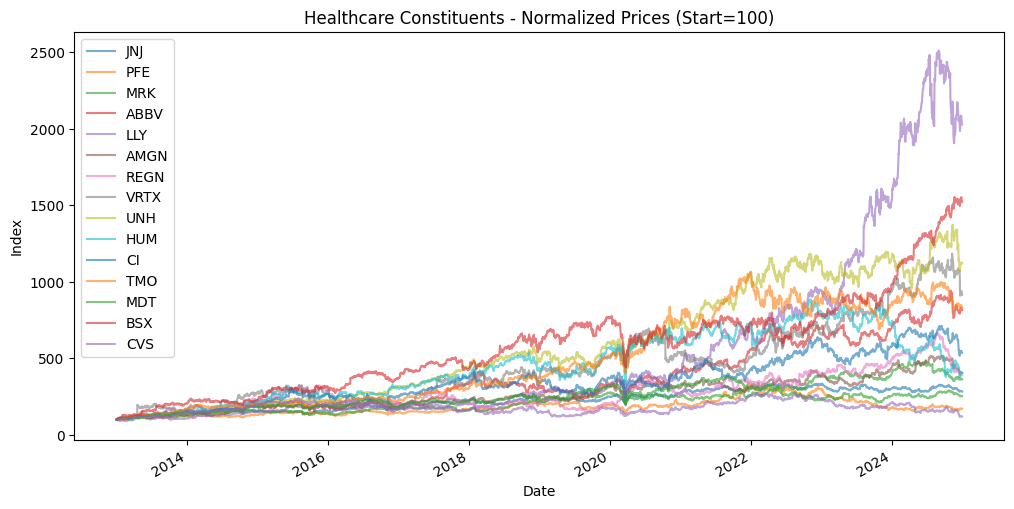

In [18]:
# Normalized price chart for constituents (start = 100)
(prices_aligned[hc_tickers] / prices_aligned[hc_tickers].iloc[0] * 100).plot(alpha=0.6)
plt.title("Healthcare Constituents - Normalized Prices (Start=100)")
plt.ylabel("Index")
plt.show()


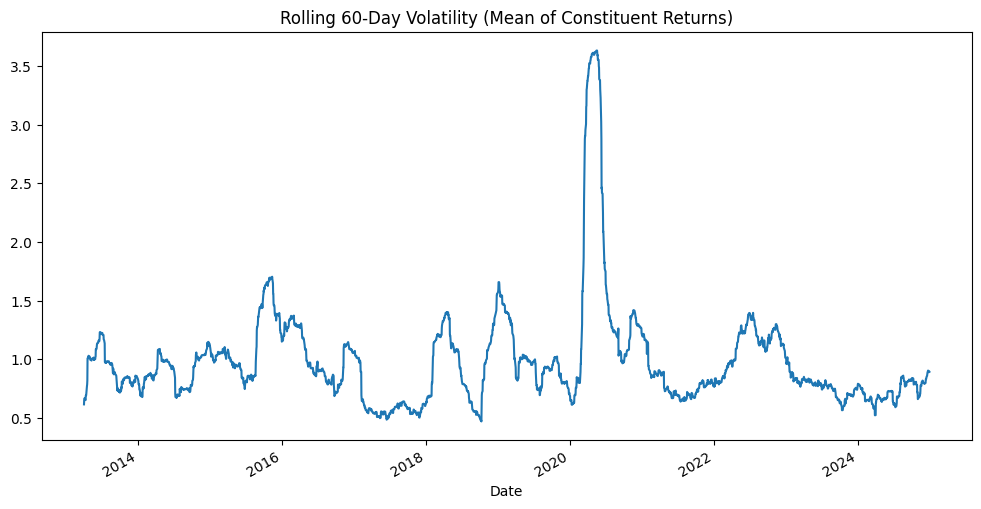

In [19]:
# Rolling 60-day volatility of the equal-weight portfolio (preview)
rolling_vol_constituents = hc_returns.mean(axis=1).rolling(60).std()
rolling_vol_constituents.plot()
plt.title("Rolling 60-Day Volatility (Mean of Constituent Returns)")
plt.show()


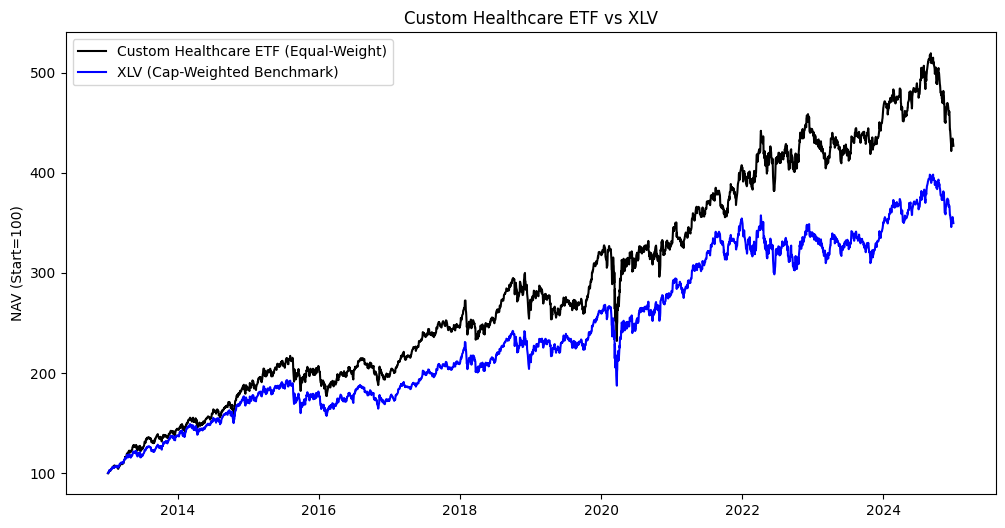

In [20]:
weights_eq = np.repeat(1/len(hc_tickers), len(hc_tickers))

# Portfolio daily returns
hc_port_ret = hc_returns.dot(weights_eq)
xlv_ret = xlv_returns

# NAV series (start=100)
hc_nav = (1 + hc_port_ret/100).cumprod() * 100
xlv_nav = (1 + xlv_ret/100).cumprod() * 100

plt.plot(hc_nav, label="Custom Healthcare ETF (Equal-Weight)", color="black")
plt.plot(xlv_nav, label="XLV (Cap-Weighted Benchmark)", color="blue")
plt.title("Custom Healthcare ETF vs XLV")
plt.ylabel("NAV (Start=100)")
plt.legend(); plt.show()


In [22]:
def perf_metrics(returns_pct: pd.Series, nav: pd.Series):
    # returns_pct are DAILY % log returns (approx for compounding)
    # metrics computed in annualized terms
    cagr = (nav.iloc[-1] / nav.iloc[0])**(252/len(nav)) - 1
    vol  = returns_pct.std() * np.sqrt(252)
    sharpe = (cagr / vol) if vol > 0 else np.nan
    maxdd = (nav / nav.cummax() - 1).min()
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": maxdd}

hc_metrics = perf_metrics(hc_port_ret, hc_nav)
xlv_metrics = perf_metrics(xlv_ret, xlv_nav)
pd.DataFrame([hc_metrics, xlv_metrics], index=["Custom Healthcare (EQW)", "XLV"])


,CAGR,Volatility,Sharpe,MaxDD
Custom Healthcare (EQW),0.129064,16.940053,0.007619,-0.291669
XLV,0.110099,16.247234,0.006776,-0.301407


In [23]:
pd.DataFrame([hc_metrics, xlv_metrics], index=["Custom Healthcare (EQW)", "XLV"])\
  .to_csv(f"{RESULTS_DIR}/healthcare_vs_xlv_metrics.csv")


In [24]:
# ETF Monte Carlo Simulation
n_sims = 1000
horizon = 252 * 25
mean_vec = hc_returns.mean().values
cov_mat  = hc_returns.cov().values

def mc_portfolio_stats(mean_vec, cov_mat, weights, horizon, n_sims=1000):
    stats = []
    navs = []
    for _ in range(n_sims):
        sim = np.random.multivariate_normal(mean_vec, cov_mat, size=horizon)
        port = sim.dot(weights)
        nav  = (1 + port/100).cumprod()
        # metrics
        cagr = (nav[-1]/nav[0])**(252/horizon) - 1
        vol  = port.std()*np.sqrt(252)
        sharpe_annual = (cagr/vol) if vol>0 else np.nan
        maxdd = (nav/np.maximum.accumulate(nav)-1).min()
        stats.append([cagr, vol, sharpe_annual, maxdd])
        navs.append(pd.Series(nav))
    stats = pd.DataFrame(stats, columns=["CAGR","Volatility","Sharpe","MaxDD"])
    navs = pd.concat(navs, axis=1)
    return stats, navs

mc_etf, navs_etf = mc_portfolio_stats(mean_vec, cov_mat, weights_eq, horizon, n_sims=n_sims)
mc_etf.describe().T


,count,mean,std,min,25%,50%,75%,max
CAGR,1000.0,0.129826,0.038406,0.013909,0.101882,0.128874,0.156701,0.248001
Volatility,1000.0,16.939182,0.149951,16.371668,16.837396,16.936283,17.037334,17.388702
Sharpe,1000.0,0.007666,0.002270,0.000815,0.006054,0.007575,0.009250,0.014544
MaxDD,1000.0,-0.360896,0.079742,-0.676212,-0.411354,-0.348772,-0.302649,-0.191798


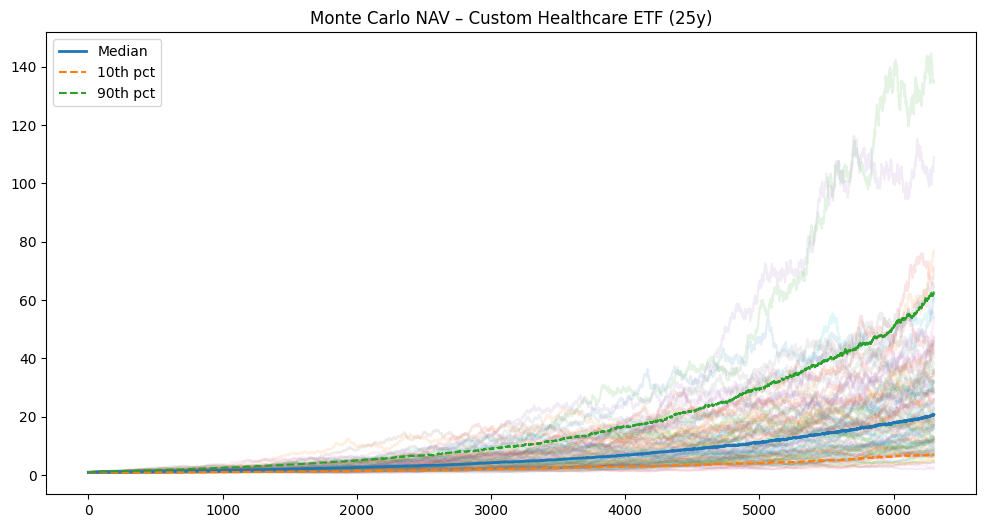

In [25]:
Q = navs_etf.quantile([0.1, 0.5, 0.9], axis=1).T
plt.plot(navs_etf.iloc[:, :100], alpha=0.12)
plt.plot(Q[0.5], label='Median', linewidth=2)
plt.plot(Q[0.1], label='10th pct', linestyle='--')
plt.plot(Q[0.9], label='90th pct', linestyle='--')
plt.title("Monte Carlo NAV – Custom Healthcare ETF (25y)")
plt.legend(); plt.show()


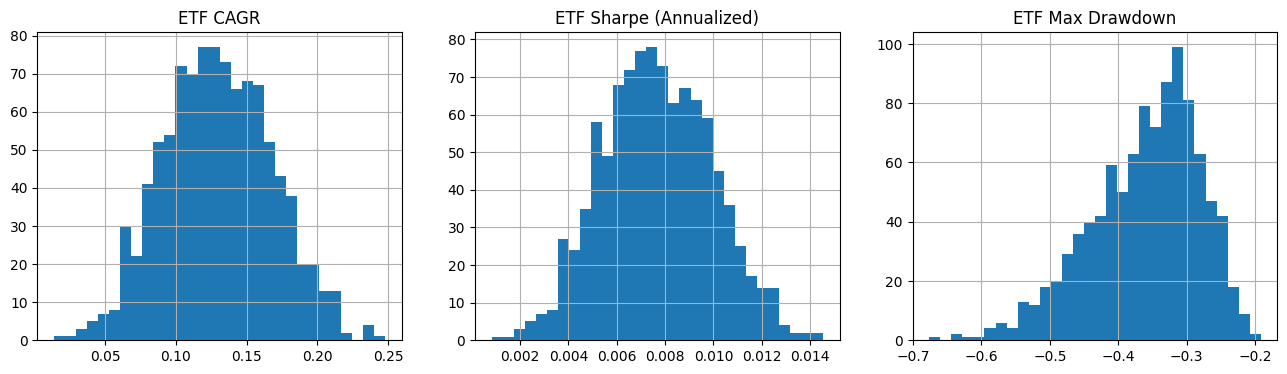

In [26]:
# Histograms for ETF
fig, axes = plt.subplots(1,3, figsize=(16,4))
mc_etf["CAGR"].hist(ax=axes[0], bins=30); axes[0].set_title("ETF CAGR")
mc_etf["Sharpe"].hist(ax=axes[1], bins=30); axes[1].set_title("ETF Sharpe (Annualized)")
mc_etf["MaxDD"].hist(ax=axes[2], bins=30); axes[2].set_title("ETF Max Drawdown")
plt.show()


sharpe not annualized (to be fixed)

In [27]:
# XLV Monte Carlo
mu_xlv  = xlv_ret.mean()
sig_xlv = xlv_ret.std()

def mc_single_asset(mu, sigma, horizon, n_sims=1000):
    stats = []
    for _ in range(n_sims):
        sim = np.random.normal(mu, sigma, size=horizon)
        nav = (1 + sim/100).cumprod()
        cagr = (nav[-1]/nav[0])**(252/horizon) - 1
        vol  = sim.std()*np.sqrt(252)
        sharpe = (cagr/vol) if vol>0 else np.nan
        maxdd = (nav/np.maximum.accumulate(nav)-1).min()
        stats.append([cagr, vol, sharpe, maxdd])
    return pd.DataFrame(stats, columns=["CAGR","Volatility","Sharpe","MaxDD"])

mc_xlv = mc_single_asset(mu_xlv, sig_xlv, horizon, n_sims=n_sims)
mc_xlv.describe().T


,count,mean,std,min,25%,50%,75%,max
CAGR,1000.0,0.109908,0.037236,-0.007739,0.083903,0.111651,0.134553,0.244304
Volatility,1000.0,16.249812,0.143503,15.743752,16.155251,16.247998,16.344446,16.757381
Sharpe,1000.0,0.006764,0.002293,-0.000475,0.005139,0.006858,0.008271,0.014948
MaxDD,1000.0,-0.364397,0.086854,-0.706854,-0.411027,-0.349739,-0.302943,-0.188575


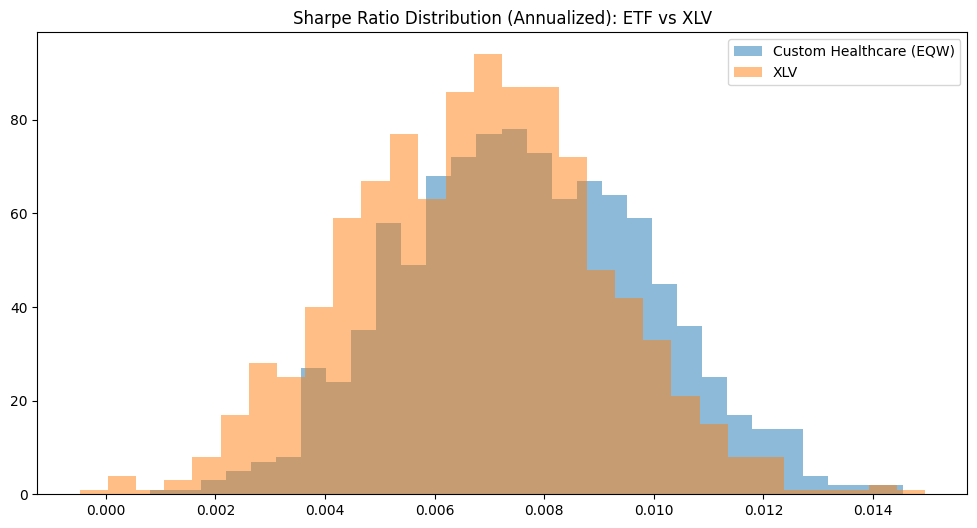

In [28]:
# Compare ETF vs XLV
plt.hist(mc_etf["Sharpe"], bins=30, alpha=0.5, label="Custom Healthcare (EQW)")
plt.hist(mc_xlv["Sharpe"], bins=30, alpha=0.5, label="XLV")
plt.title("Sharpe Ratio Distribution (Annualized): ETF vs XLV")
plt.legend(); plt.show()

# Save
mc_etf.to_csv(f"{RESULTS_DIR}/mc_etf_stats.csv", index=False)
mc_xlv.to_csv(f"{RESULTS_DIR}/mc_xlv_stats.csv", index=False)


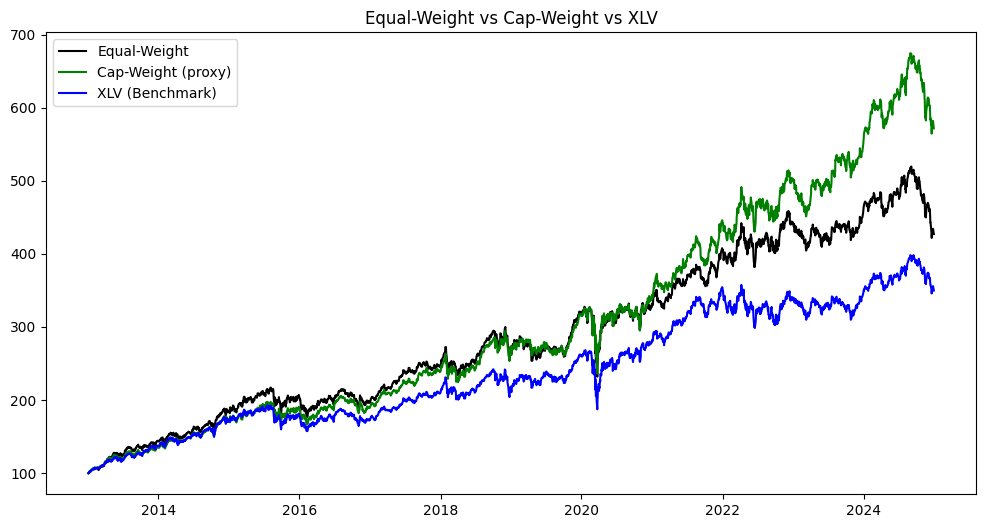

,CAGR,Volatility,Sharpe,MaxDD
Healthcare EQW,0.129064,16.940053,0.007619,-0.291669
Healthcare CapW (proxy),0.156911,16.682250,0.009406,-0.278587
XLV,0.110099,16.247234,0.006776,-0.301407


In [29]:
caps = {}
for t in hc_tickers:
    try:
        info = yf.Ticker(t).fast_info
        caps[t] = info.market_cap
        time.sleep(0.2)
    except Exception:
        caps[t] = np.nan

caps = pd.Series(caps).dropna()
cw = (caps / caps.sum()).reindex(hc_tickers).fillna(0).values

hc_cw_ret = hc_returns.dot(cw)
hc_cw_nav = (1 + hc_cw_ret/100).cumprod() * 100

plt.plot(hc_nav, label="Equal-Weight", color="black")
plt.plot(hc_cw_nav, label="Cap-Weight (proxy)", color="green")
plt.plot(xlv_nav, label="XLV (Benchmark)", color="blue")
plt.title("Equal-Weight vs Cap-Weight vs XLV")
plt.legend(); plt.show()

pd.DataFrame([
    perf_metrics(hc_port_ret, hc_nav),
    perf_metrics(hc_cw_ret, hc_cw_nav),
    perf_metrics(xlv_ret, xlv_nav)
], index=["Healthcare EQW","Healthcare CapW (proxy)","XLV"])
